In [1]:
import time
script_start_time = time.time()

import pandas as pd
import numpy as np
from progressbar import ProgressBar, Bar, Percentage

from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import os
import cv2
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
start_time = time.time()

api = KaggleApi()
api.authenticate()
api.dataset_download_files('kmader/pulmonary-chest-xray-abnormalities')

print('Files downloaded.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))

Files downloaded.
Time elapsed: 00:00:00


In [3]:
start_time = time.time()

with ZipFile('pulmonary-chest-xray-abnormalities.zip', 'r') as zip_ref:
    zip_ref.extractall('xray_images')
    
print('Files unzipped.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))

Files unzipped.
Time elapsed: 00:00:26


In [4]:
def encode_images():
    
    start_time = time.time()
    
    X = []
    y = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                X.append(cv2.imread(directory + filename))
                y.append(int(filename[-5]))
                counter += 1
                bar.update(counter)

    bar.finish()
    
    print('Images encoded.')
    print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
    
    return np.array(X), np.array(y)

In [5]:
X, y = encode_images()

[========================================================================] 100%


Images encoded.
Time elapsed: 00:02:57


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [6]:
def plot_dimensions(X, save=False):
    
    heights = [i.shape[0] for i in X]
    widths = [i.shape[1] for i in X]
    
    dimensions = [widths, heights]
    xlabels = ['heights (pixels)', 'widths (pixels)']
    
    fig = plt.figure(figsize=(14, 6))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Avenir'
    for i in range(len(dimensions)):
        print((min(dimensions[i]), max(dimensions[i])), min(dimensions[i]) == max(dimensions[i]))
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(dimensions[i], bins=20)
        ax.set_xlabel(xlabels[i], fontsize=14)
    
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig('xray_visualisations/dimensions.png')

(1130, 4892) False
(948, 4892) False


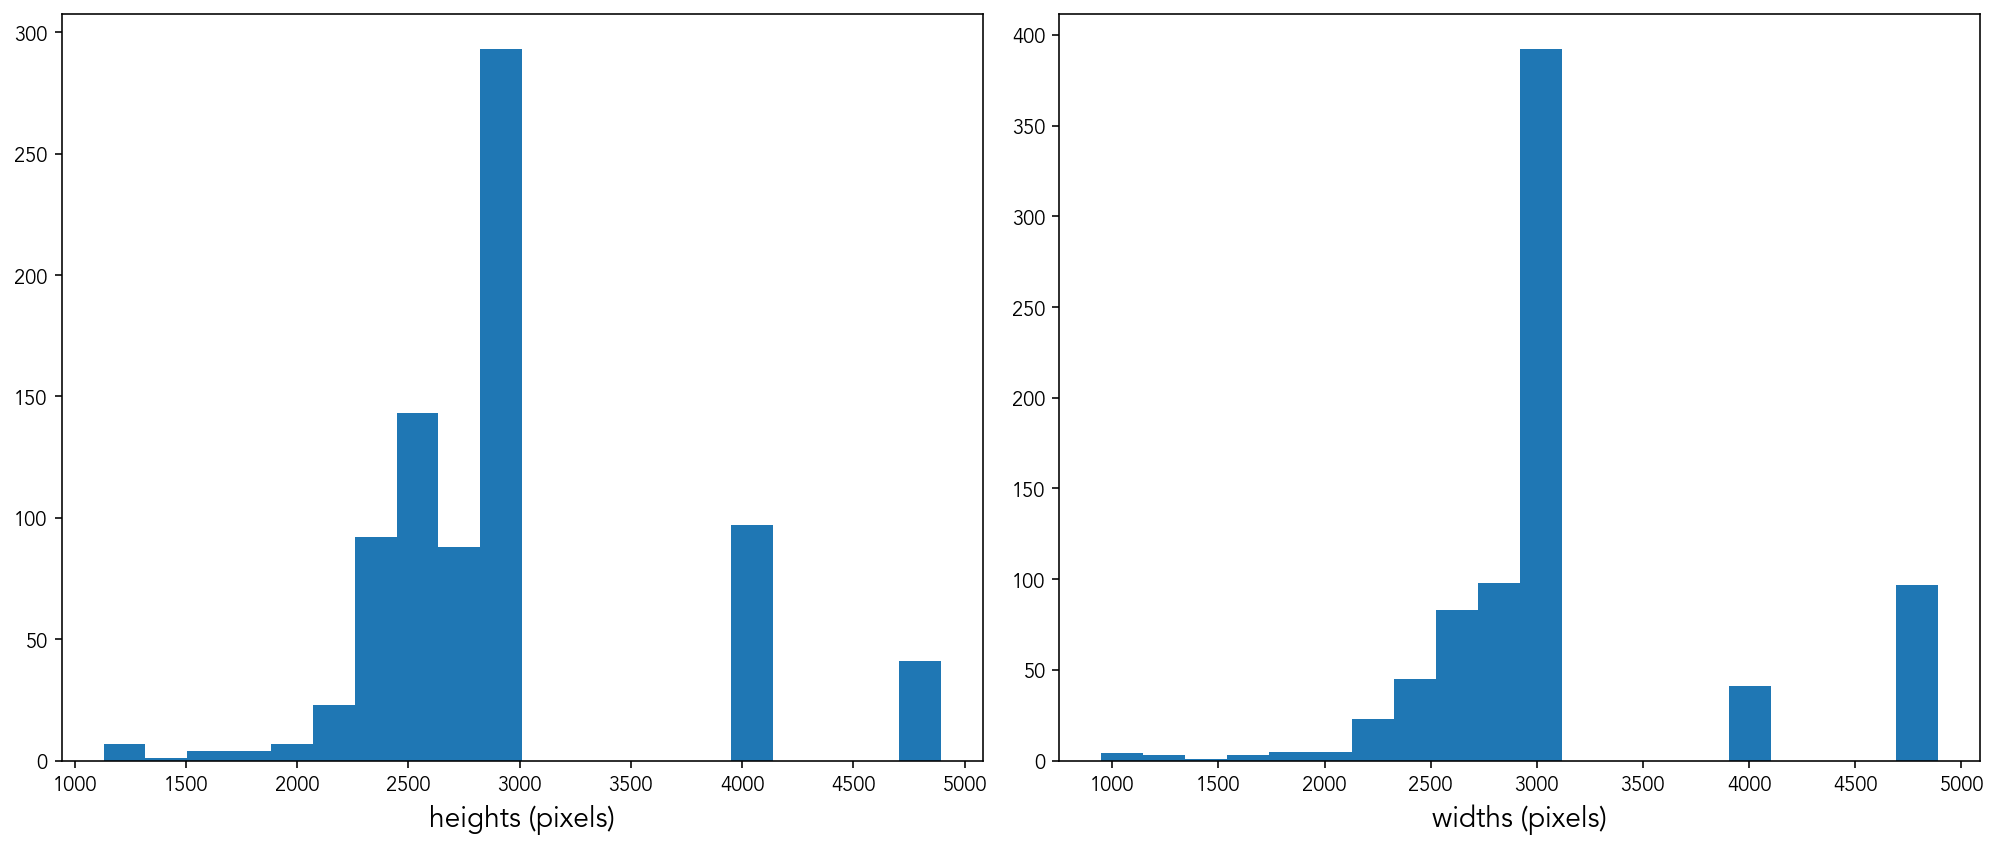

In [7]:
plot_dimensions(X, save=True)

In [8]:
def resize_encode_images():
    
    start_time = time.time()
    
    X = []
    y = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                img = Image.open(directory + filename)
                img = img.resize((256, 256))
                img.save(directory + filename)
                X.append(cv2.imread(directory + filename))
                y.append(int(filename[-5]))
                counter += 1
                bar.update(counter)

    bar.finish()
    
    print('Images resized and encoded.')
    print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
    
    return np.array(X), np.array(y)

In [9]:
X, y = resize_encode_images()

[========================================================================] 100%


Images resized and encoded.
Time elapsed: 00:02:55


(256, 256) True
(256, 256) True


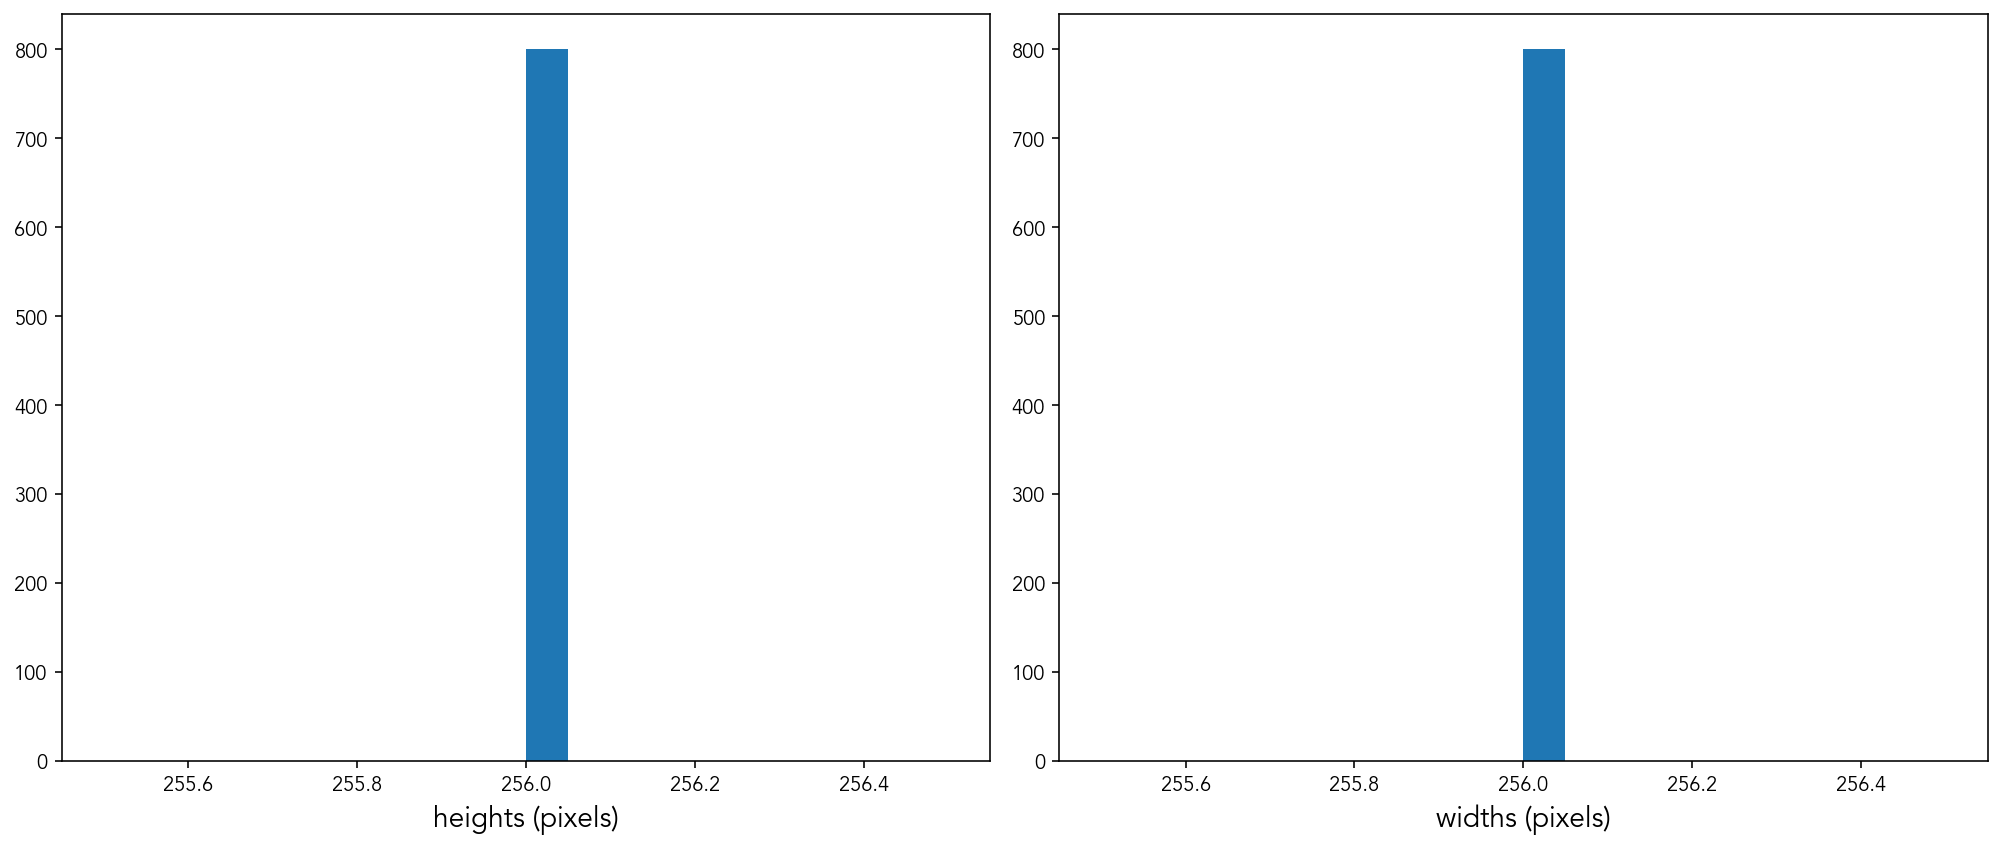

In [10]:
plot_dimensions(X)

In [11]:
print((np.min(X), np.max(X)))
X = X.astype('float32') / 255
print((np.min(X), np.max(X)))

(0, 255)
(0.0, 1.0)


In [12]:
set(y) == {0, 1}

True

In [13]:
np.mean(y)

0.4925

In [14]:
def plot_target(y):
    
    k, v = np.unique(y, return_counts=True)
    y_counts = dict(zip(k, v))
    
    fig = plt.figure(figsize=(8, 8))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Avenir'
    ax = fig.add_subplot(1, 1, 1)
    ax.pie(y_counts.values(), startangle=90, colors=['lightblue', 'steelblue'], 
          explode=(0.05, 0), autopct='%.2f%%', wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, 
          textprops={'fontsize': 18, 'fontweight': 'bold'})
    circle1 = Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markeredgecolor='black', 
                     markersize=22)
    circle2 = Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markeredgecolor='black', 
                     markersize=22)
    ax.legend(labels=y_counts.keys(), handles=[circle1, circle2], fontsize=18, framealpha=0)
    
    plt.tight_layout()
    plt.show()
    fig.savefig('xray_visualisations/target.png')

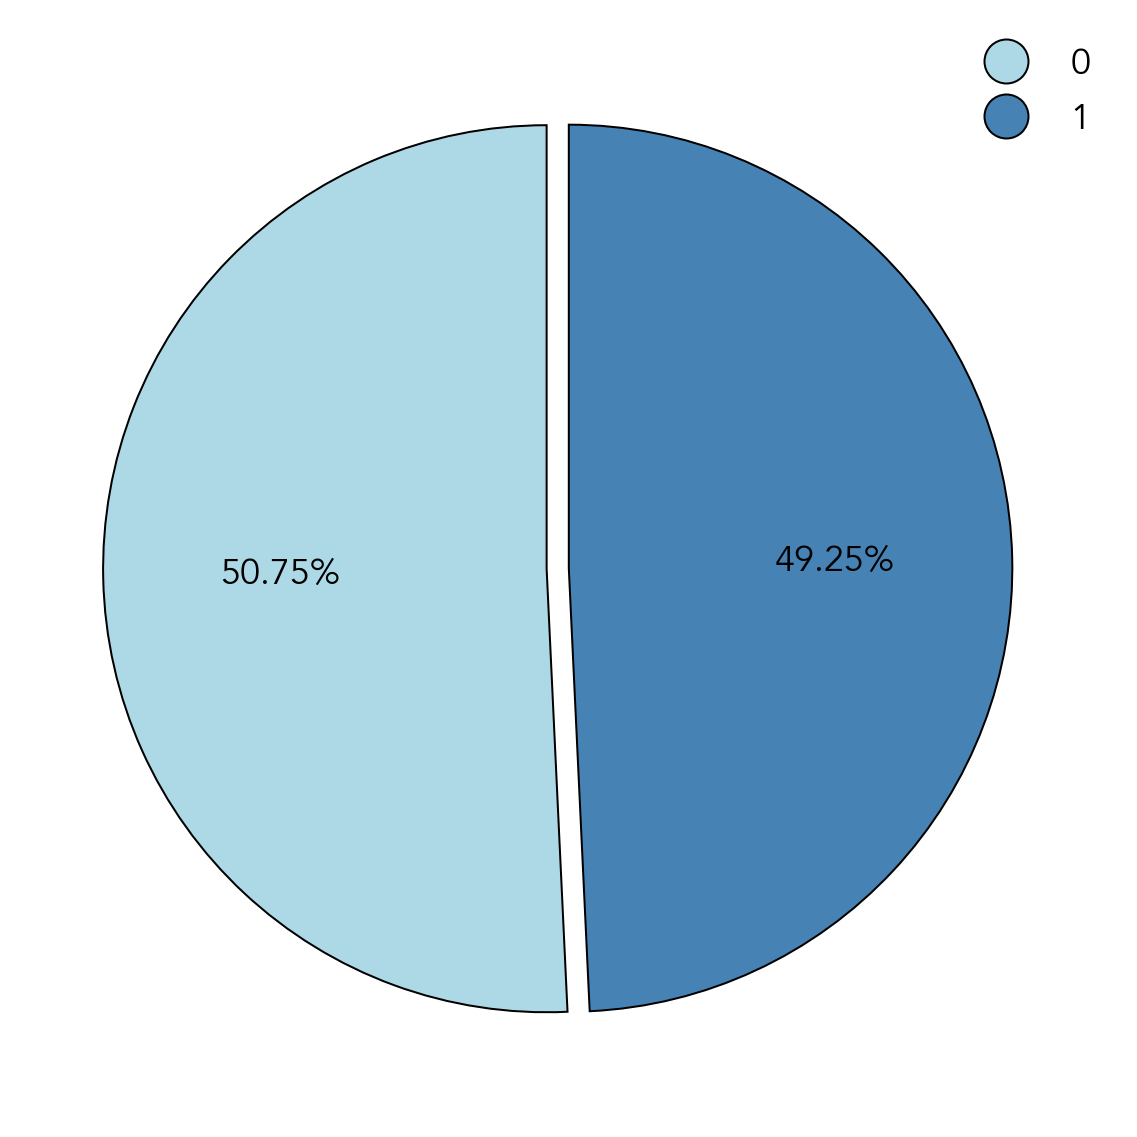

In [15]:
plot_target(y)

In [16]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(val_size + test_size), random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=(test_size / (val_size + test_size)), 
                                                random_state=42)

print('Training: {}; Validation: {}; Testing: {}'.format((len(X_train), len(y_train)), (len(X_val), len(y_val)), 
                                                      (len(X_test), len(y_test))))

Training: (480, 480); Validation: (160, 160); Testing: (160, 160)


In [17]:
y_train = keras.utils.to_categorical(y_train, len(set(y)))
y_val = keras.utils.to_categorical(y_val, len(set(y)))
y_test = keras.utils.to_categorical(y_test, len(set(y)))

print(y_train.shape, y_val.shape, y_test.shape)

(480, 2) (160, 2) (160, 2)


In [18]:
base_model = Sequential()
base_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
base_model.add(MaxPooling2D(pool_size=2))
base_model.add(Flatten())
base_model.add(Dense(len(set(y)), activation='softmax'))

base_model.summary()

base_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(base_model.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 524290    
Total params: 524,498
Trainable params: 524,498
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Epoch 1/10
15/15 [==============================] - 9s 506ms/step - loss: 36.6181 - accuracy: 0.4833 - val_loss: 9.4831 - val_accuracy: 0.5750
Epoch 2/10
15/15 [==============================] - 7s 441ms/step - loss: 9.7117 - accur

In [19]:
# epochs = [5, 10, 20, 50, 100, 200]
# scores = []

# n = len(epochs)

# counter = 0

# bar = ProgressBar(maxval=n+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
# bar.start()

# for e in epochs:
#     test_model = Sequential()
#     test_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
#     test_model.add(MaxPooling2D(pool_size=2))
#     test_model.add(Flatten())
#     test_model.add(Dense(len(set(y)), activation='softmax'))
#     test_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     test_model.fit(X_train, y_train, epochs=e, batch_size=32, validation_data=(X_val, y_val), verbose=False, 
#                    shuffle=True)
#     scores.append(test_model.evaluate(X_test, y_test, verbose=False)[1])
#     counter += 1
#     bar.update(counter)

# bar.finish()

In [20]:
# fig = plt.figure(figsize=(12, 8))
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Avenir'
# ax = fig.add_subplot(1, 1, 1)

# ax.plot(epochs, scores, color='steelblue', marker='o')
# ax.set_xticks(epochs)
# ax.set_xticklabels(epochs, fontsize=14)
# ax.set_ylim(0.7, 0.9)
# ax.set_yticks([i/100 for i in range(70, 91, 5)])
# ax.set_yticklabels([i/100 for i in range(70, 91, 5)], fontsize=14)
# ax.set_xlabel('Epochs', fontsize=18)
# ax.set_ylabel('Accuracy Score', fontsize=18)

# ax.yaxis.grid(True, color='#EEEEEE')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('grey')
# ax.spines['bottom'].set_color('grey')
# ax.tick_params(left=False)

# plt.tight_layout()
# plt.show()
# fig.savefig('xray_visualisations/epochs.png')

In [21]:
datagen_train = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen_val = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

datagen_train.fit(X_train)
datagen_val.fit(X_val)

In [ ]:
aug_base_model = Sequential()
aug_base_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
aug_base_model.add(MaxPooling2D(pool_size=2))
aug_base_model.add(Flatten())
aug_base_model.add(Dense(len(set(y)), activation='softmax'))

aug_base_model.summary()

aug_base_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

batch_size = 32

aug_base_model.fit(datagen_train.flow(X_train, y_train, batch_size=batch_size), 
                   steps_per_epoch=X_train.shape[0] / batch_size, epochs=20, verbose=0, 
                   validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size), 
                   validation_steps=X_val.shape[0] / batch_size)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(aug_base_model.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 524290    
Total params: 524,498
Trainable params: 524,498
Non-trainable params: 0
_________________________________________________________________
Fitting model...


In [23]:
# add two more convolutional layers

model1 = Sequential()
model1.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(len(set(y)), activation='softmax'))

print(model1.summary())

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(model1.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)            

In [24]:
# additional dense layer

model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(len(set(y)), activation='softmax'))

print(model2.summary())

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(model2.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)            

In [25]:
# remove dense layer and add dropout

model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(len(set(y)), activation='softmax'))

print(model3.summary())

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(model3.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)       

In [26]:
# added stride

model4 = Sequential()
model4.add(Conv2D(filters=16, kernel_size=2, strides=2, padding='same', activation='relu', input_shape=X[0].shape))
model4.add(MaxPooling2D(pool_size=2))
model4.add(Conv2D(filters=32, kernel_size=2, strides=2, padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=2))
model4.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=2))
model4.add(Dropout(0.3))
model4.add(Flatten())
model4.add(Dense(len(set(y)), activation='softmax'))

print(model4.summary())

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

model4.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(model4.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)         

In [27]:
# test sigmoid activation

model5 = Sequential()
model5.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='sigmoid', input_shape=X[0].shape))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='sigmoid'))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='sigmoid'))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Dropout(0.3))
model5.add(Flatten())
model5.add(Dense(len(set(y)), activation='softmax'))

print(model5.summary())

model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

start_time = time.time()
print('Fitting model...')

model5.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=True)

print('='*65)
print('Fitting complete.')
print('Time elapsed: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))))
print('Test accuracy: {}'.format(str(round(model5.evaluate(X_test, y_test, verbose=0)[1], 4))))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)       

In [28]:
print('Script runtime: {}'.format(str(time.strftime('%H:%M:%S', time.gmtime(time.time() - script_start_time)))))

Script runtime: 00:25:38
